<a href="https://www.kaggle.com/code/haleyparmley/nfl-big-data-bowl-2025-predicting-receiver-routes?scriptVersionId=216257074" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import logging
import os
import numpy as np

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
def load_and_prepare_data():
    """
    Loads, prepares, and merges data from various CSV files, adding advanced football-specific features
    and including height and weight of the running back as well as positional group averages.

    Returns:
        tuple: X (features), y (target).
    """
    try:
        print("Loading datasets...")

        # Load player-play data
        player_play_data = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2025/player_play.csv", usecols=[
            "routeRan", "nflId", "playId", "gameId", "inMotionAtBallSnap"
        ]).dropna(subset=["routeRan"])

        # Load play data
        play_data = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2025/plays.csv", usecols=[
            "quarter", "down", "yardsToGo", "possessionTeam", "defensiveTeam", "yardlineSide", "yardlineNumber",
            "gameClock", "preSnapHomeScore", "preSnapVisitorScore", "absoluteYardlineNumber",
            "preSnapHomeTeamWinProbability", "preSnapVisitorTeamWinProbability", "expectedPoints",
            "offenseFormation", "receiverAlignment", "gameId", "playId"
        ])

        # Convert game clock to seconds
        def game_clock_to_seconds(clock):
            try:
                minutes, seconds = map(int, clock.split(":"))
                return minutes * 60 + seconds
            except Exception:
                return np.nan

        # Filter for plays with less than two minutes left in quarter
        play_data["seconds_left_in_quarter"] = play_data["gameClock"].apply(game_clock_to_seconds)
        play_data = play_data[play_data["seconds_left_in_quarter"] <= 120]

        # Load player data
        player_data = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2025/players.csv", usecols=[
            "height", "weight", "collegeName", "nflId", "position"
        ])

        # Load game data
        game_data = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2025/games.csv", usecols=[
            "gameId", "week", "homeTeamAbbr", "visitorTeamAbbr"
        ])

        # Load and filter tracking data
        tracking_data_combined = pd.concat(
            [
                pd.read_csv(file, usecols=[
                    "gameId", "playId", "nflId", "playDirection", "x", "y", "frameType", "event"
                ]).query("frameType == 'BEFORE_SNAP'")
                for file in [f"/kaggle/input/nfl-big-data-bowl-2025/tracking_week_{i}.csv" for i in range(1, 10)]
            ],
            ignore_index=True
        )

        print("Merging datasets...")

        # Merge datasets
        player_play_merged = pd.merge(player_play_data, player_data, on="nflId")
        play_game_merged = pd.merge(play_data, game_data, on="gameId")
        final_data = pd.merge(player_play_merged, play_game_merged, on=["playId", "gameId"])
        final_data = pd.merge(final_data, tracking_data_combined, on=["gameId", "playId", "nflId"])

        # Drop unnecessary columns
        final_data = final_data.drop(columns=["gameId", "frameType", "gameClock"])

        # Create features and target
        x = final_data.drop(columns=["routeRan"])
        y = final_data["routeRan"]

        # Validate shapes
        print(f"x shape: {x.shape}, y shape: {y.shape}")
        if len(x) != len(y):
            raise ValueError("Mismatch in number of rows between features and target.")

        return x, y

    except Exception as e:
        print(f"An error occurred: {e}")
        raise

In [3]:
def split_and_save_data(x, y, test_size=0.2, random_state=42):
    """
    Splits the data into training and test sets based on plays (playId) and saves them to CSV files.
    """
    try:
        print("Splitting data into training and test sets based on playId...")

        # Use GroupShuffleSplit to split data by playId
        plays = x['playId']  # Ensure playId is present in x
        splitter = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=random_state)
        train_idx, test_idx = next(splitter.split(x, y, plays))

        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Validate shapes
        print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
        print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
        if len(x_train) != len(y_train) or len(x_test) != len(y_test):
            raise ValueError("Mismatch in lengths after splitting.")

        # Save the split datasets
        logging.info("Saving training and testing datasets...")
        x_train.to_csv(os.path.join("/kaggle/working/x_train.csv"), index=False)
        x_test.to_csv(os.path.join("/kaggle/working/x_test.csv"), index=False)
        y_train.to_csv(os.path.join("/kaggle/working/y_train.csv"), index=False)
        y_test.to_csv(os.path.join("/kaggle/working/y_test.csv"), index=False)

        print("Datasets saved successfully.")
        return x_train, x_test, y_train, y_test

    except Exception as e:
        print(f"An error occurred during data splitting: {e}")
        raise

In [4]:
def main():
    """Main execution function."""
    try:
        x, y = load_and_prepare_data()
        x_train, x_test, y_train, y_test = split_and_save_data(x, y)
    
        logging.info("Program execution completed successfully.")
    except Exception as e:
        logging.error(f"Program terminated with an exception: {e}")


if __name__ == "__main__":
    main()

Loading datasets...
Merging datasets...
x shape: (856419, 30), y shape: (856419,)
Splitting data into training and test sets based on playId...
x_train shape: (681348, 30), y_train shape: (681348,)
x_test shape: (175071, 30), y_test shape: (175071,)
Datasets saved successfully.


In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import joblib
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [6]:
def load_and_preprocess_data():
    """Loads, preprocesses, and returns the training and testing datasets."""
    try:
        print("Loading datasets...")
        x_train = pd.read_csv("/kaggle/working/x_train.csv")
        x_test = pd.read_csv("/kaggle/working/x_test.csv")
        y_train = pd.read_csv("/kaggle/working/y_train.csv").squeeze()
        y_test = pd.read_csv("/kaggle/working/y_test.csv").squeeze()

        logging.info("Data loaded successfully.")
        return x_train, x_test, y_train, y_test
    
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

In [7]:
def create_pipeline(x_train):
    """Creates a preprocessing pipeline and returns it."""
    try:
        print("Creating preprocessing pipeline...")

        # Identify numeric and categorical columns
        numeric_columns = x_train.select_dtypes(include=['float64', 'int64']).columns
        categorical_columns = x_train.select_dtypes(include=['object', 'bool']).columns

        if numeric_columns.empty and categorical_columns.empty:
            raise ValueError("No numeric or categorical columns found in x_train.")

        # Define preprocessing steps for numeric data
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        # Define preprocessing steps for categorical data
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        # Column transformer
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_columns),
                ('cat', categorical_transformer, categorical_columns)
            ],
            remainder='drop'  # Drop unprocessed columns
        )

        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                random_state=42, 
                class_weight='balanced', 
                n_estimators=100, 
                max_depth=20
            ))
        ])

        print("Pipeline created successfully.")
        return pipeline

    except Exception as e:
        print(f"Error creating pipeline: {e}")
        raise

In [8]:
def train_and_evaluate_model(pipeline, x_train, x_test, y_train, y_test):
    """
    Trains and evaluates a RandomForestClassifier model.
    Args:
        pipeline: The preprocessing and training pipeline.
        x_train: Training features.
        x_test: Testing features.
        y_train: Training labels.
        y_test: Testing labels.
    """
    try:
        print("Training RandomForestClassifier model...")
        pipeline.fit(x_train, y_train)

        # Extract feature importances
        rf_model = pipeline.named_steps['classifier']
        feature_importances = rf_model.feature_importances_

        print("Evaluating model on the testing set...")
        y_pred = pipeline.predict(x_test)

        # Evaluate performance
        test_accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"Testing Set Accuracy: {test_accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        return pipeline

    except Exception as e:
        print(f"Error training or evaluating model: {e}")
        raise

In [9]:
def visualize_model_results(x_train, y_test, y_pred, pipeline, top_n_features=10):
    """
    Generates visualizations of model performance, feature importance, and NFL-relevant data insights.
    Args:
        x_train: Training features used in the model.
        y_test: True labels for the test set.
        y_pred: Predicted labels from the model.
        pipeline: Trained machine learning pipeline.
        top_n_features: Number of top features to display in feature importance plots.
    """
    try:
        print("Generating visualizations...")

        # Confusion Matrix
        plt.figure(figsize=(10, 7))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_test.unique(), yticklabels=y_test.unique())
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.tight_layout()
        plt.show()

        # Classification Report Heatmap
        report = classification_report(y_test, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        plt.figure(figsize=(10, 6))
        sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title("Classification Report Heatmap")
        plt.tight_layout()
        plt.show()

        # Feature Importance
        rf_model = pipeline.named_steps['classifier']
        feature_importances = rf_model.feature_importances_
        feature_names = (
            pipeline.named_steps['preprocessor'].transformers_[0][2].tolist() +
            pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out().tolist()
        )
        importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
        importance_df = importance_df.sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x="importance", y="feature", data=importance_df.head(top_n_features), palette="viridis")
        plt.title("Top Feature Importance")
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature Names")
        plt.tight_layout()
        plt.show()

        # Distribution of Predicted Routes
        plt.figure(figsize=(10, 6))
        sns.countplot(x=y_pred, palette="muted")
        plt.title("Distribution of Predicted Routes")
        plt.xlabel("Predicted Route")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during visualization: {e}")
        raise


Loading datasets...
Creating preprocessing pipeline...
Pipeline created successfully.
Training RandomForestClassifier model...
Evaluating model on the testing set...
Testing Set Accuracy: 0.2427
F1 Score: 0.2343

Classification Report:
              precision    recall  f1-score   support

       ANGLE       0.35      0.39      0.37      8279
      CORNER       0.11      0.07      0.09      8407
       CROSS       0.20      0.22      0.21     14524
        FLAT       0.42      0.46      0.44     23459
          GO       0.27      0.37      0.31     30554
       HITCH       0.20      0.16      0.18     25454
          IN       0.19      0.19      0.19     16537
         OUT       0.19      0.14      0.16     18658
        POST       0.13      0.18      0.15     12216
      SCREEN       0.20      0.11      0.14      5971
       SLANT       0.14      0.09      0.11     10363
       WHEEL       0.00      0.00      0.00       649

    accuracy                           0.24    175071
   mac

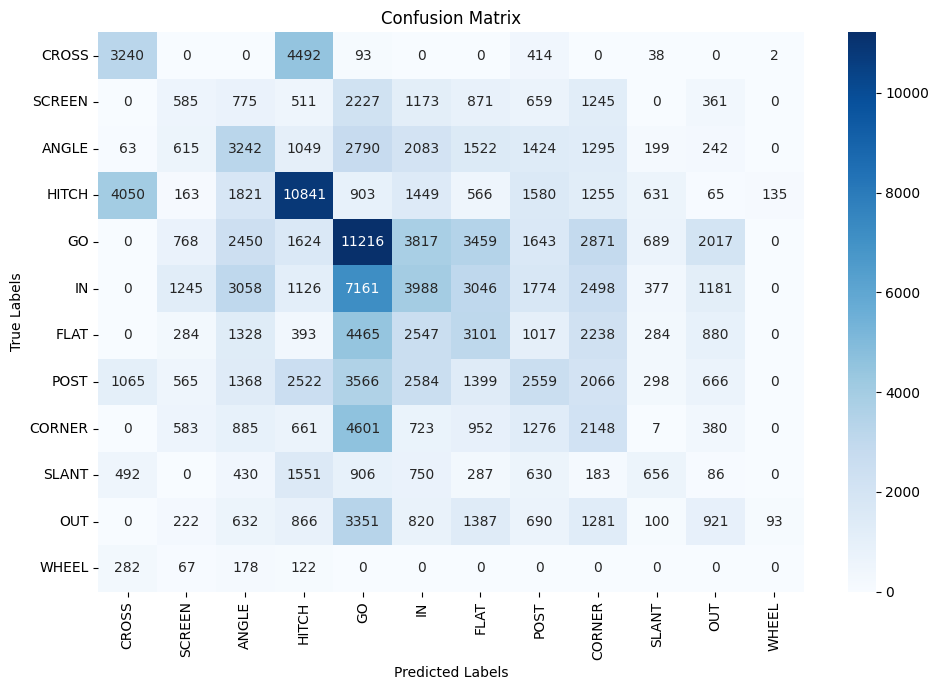

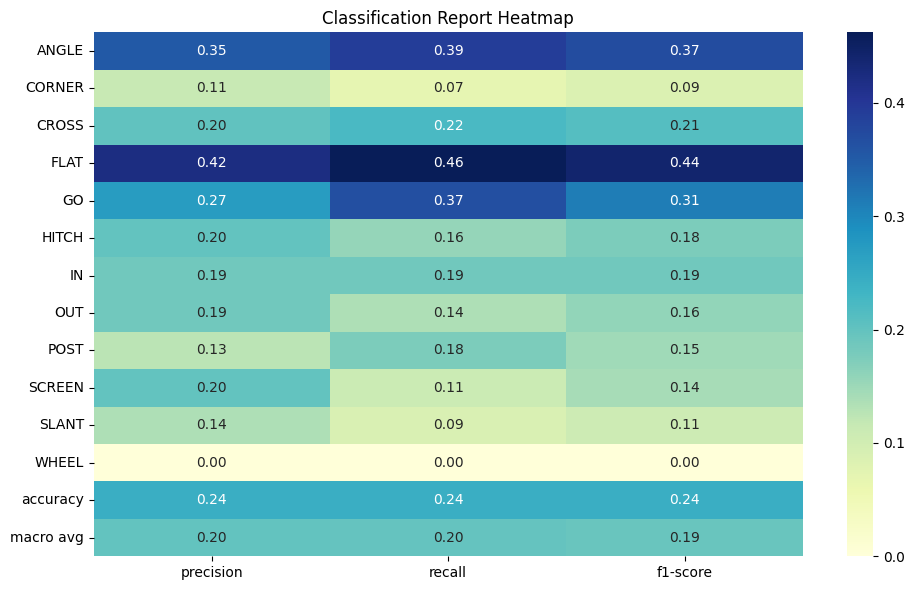

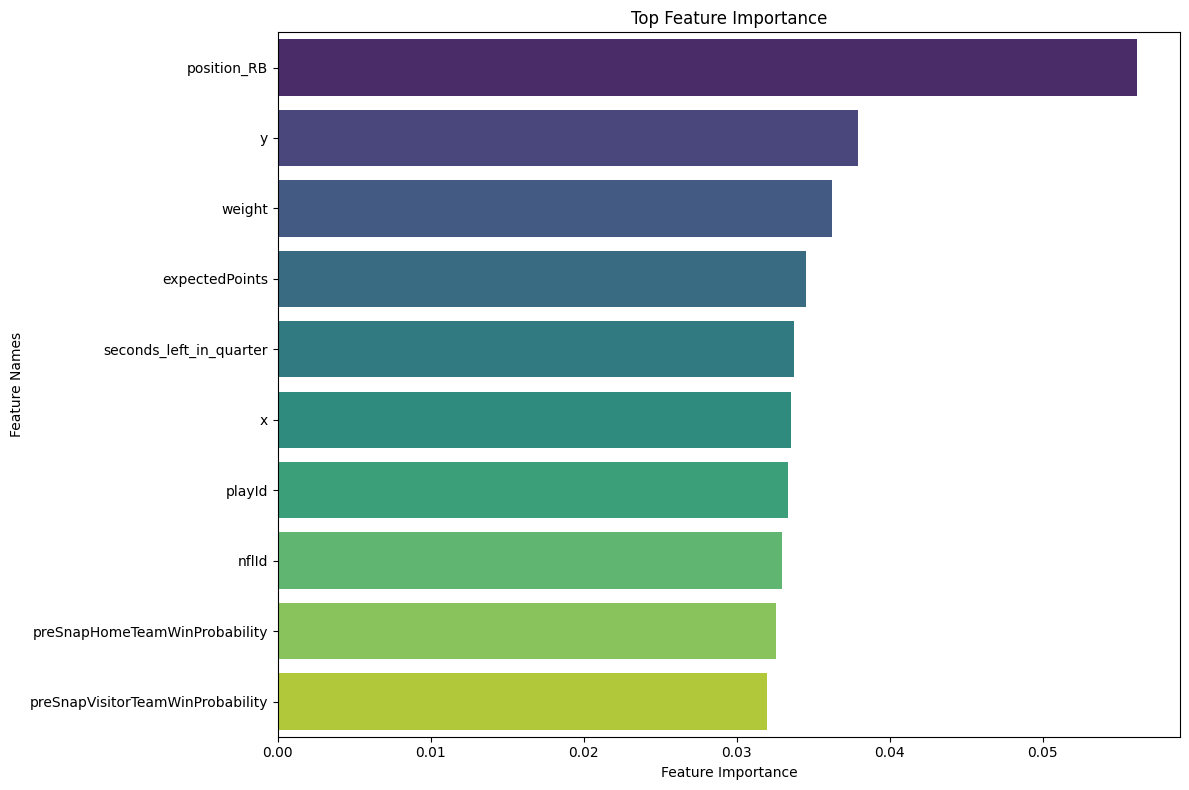

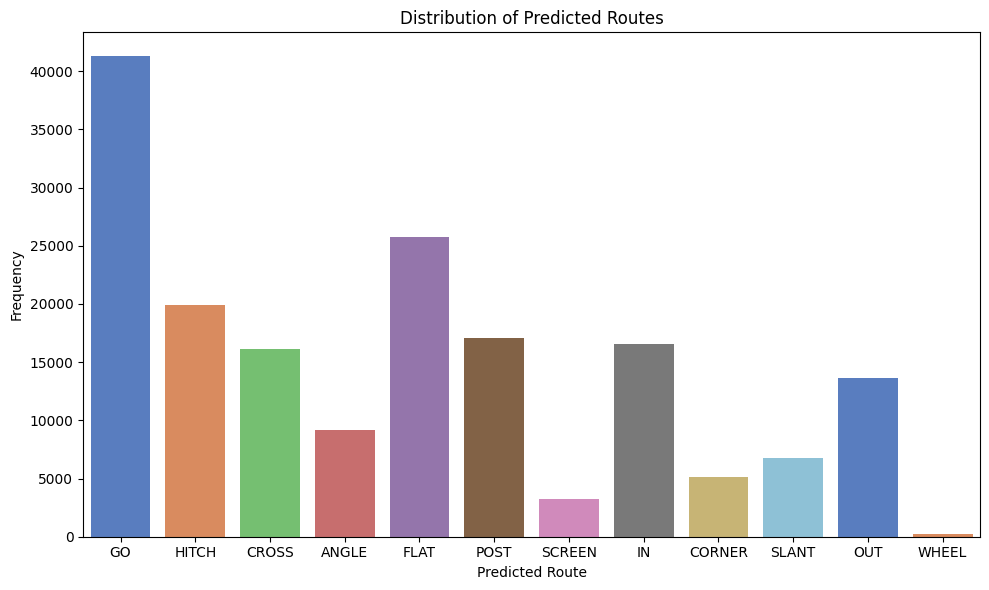

Program execution completed successfully.


In [10]:
def main():
    """Main execution function."""
    try:
        x_train, x_test, y_train, y_test = load_and_preprocess_data()
        pipeline = create_pipeline(x_train)

        # Train and evaluate model
        pipeline = train_and_evaluate_model(pipeline, x_train, x_test, y_train, y_test)
        
        # Visualize model results
        visualize_model_results(
        x_train=x_train,                 # Training features
        y_test=y_test,                   # True labels for the test set
        y_pred=pipeline.predict(x_test), # Predicted labels from the pipeline
        pipeline=pipeline,               # The trained pipeline object
        top_n_features=10                # Number of top features to display in the feature importance plot
)

        print("Program execution completed successfully.")

    except Exception as e:
        print(f"Program terminated with an exception: {e}")

if __name__ == "__main__":
    main()